In [1]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 tensorflow-hub opencv-python matplotlib

     -------------------------------------- 438.0/438.0 MB 2.9 MB/s eta 0:00:00
  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
  Using cached opencv_python-4.5.5.64-cp36-abi3-win_amd64.whl (35.4 MB)
     ---------------------------------------- 7.2/7.2 MB 21.9 MB/s eta 0:00:00
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached libclang-14.0.1-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
     ------------------------------------- 904.1/904.1 kB 14.2 MB/s eta 0:00:00
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     ---------------------------------------- 1.5/1.5 MB 18.5 MB/s eta 0:00:00
     --------------------------------------- 14.7/14.7 MB 21.8 MB/s eta 0:00:00
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
     ---------------

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.expertimental.set_memory_growth(gpu, True)

In [2]:
model= hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')

In [3]:
movenet= model.signatures['serving_default']

In [5]:
cap= cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame= cap.read()
  cv2.imshow('Movenet Multipose Window', frame)

  if cv2.waitKey(10) & 0xFF==ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

In [12]:
frame

array([[[55, 36, 39],
        [58, 35, 36],
        [61, 35, 35],
        ...,
        [49, 42, 27],
        [51, 43, 30],
        [52, 44, 31]],

       [[49, 35, 37],
        [53, 34, 36],
        [57, 34, 35],
        ...,
        [49, 41, 29],
        [50, 41, 31],
        [51, 42, 32]],

       [[43, 34, 37],
        [48, 34, 37],
        [53, 34, 37],
        ...,
        [47, 40, 30],
        [48, 41, 32],
        [49, 42, 33]],

       ...,

       [[27, 26, 24],
        [26, 26, 24],
        [26, 27, 25],
        ...,
        [46, 51, 39],
        [46, 52, 41],
        [46, 52, 41]],

       [[25, 25, 25],
        [25, 25, 25],
        [25, 25, 25],
        ...,
        [46, 50, 35],
        [46, 51, 36],
        [47, 52, 37]],

       [[25, 25, 25],
        [25, 25, 25],
        [25, 25, 25],
        ...,
        [45, 49, 34],
        [45, 50, 35],
        [45, 50, 35]]], dtype=uint8)

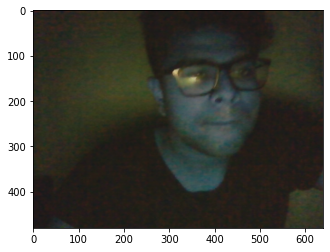

In [11]:
plt.imshow(frame)

In [106]:
cap= cv2.VideoCapture('football.mp4')
while cap.isOpened():
  ret, frame= cap.read()

  img= frame.copy()
  img= tf.image.resize_with_pad(tf.expand_dims(img, axis= 0), 544, 1024)
  input_img= tf.cast(img, dtype= tf.int32)
  
  results= movenet(input_img)
  keypoints_and_scores= results['output_0'].numpy()[:, :, :51].reshape((6, 17, 3))  
  
  loop_through_people(frame, keypoints_and_scores, EDGES, 0.3)

  cv2.imshow('Movenet Multipose Window', frame)

  if cv2.waitKey(10) & 0xFF==ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

In [91]:
1080/2048

0.52734375

In [102]:
1024/32

32.0

In [103]:
32*17

544

In [98]:
frame

array([[[189, 184, 185],
        [189, 184, 185],
        [189, 184, 185],
        ...,
        [187, 187, 208],
        [187, 187, 208],
        [187, 187, 208]],

       [[189, 184, 185],
        [189, 184, 185],
        [189, 184, 185],
        ...,
        [187, 187, 208],
        [187, 187, 208],
        [187, 187, 208]],

       [[189, 182, 188],
        [189, 182, 188],
        [189, 182, 188],
        ...,
        [186, 186, 207],
        [186, 186, 207],
        [186, 186, 207]],

       ...,

       [[ 46,  75,  77],
        [ 46,  75,  77],
        [ 46,  75,  77],
        ...,
        [ 39,  68,  70],
        [ 39,  68,  70],
        [ 39,  68,  70]],

       [[ 44,  73,  75],
        [ 45,  74,  76],
        [ 45,  74,  76],
        ...,
        [ 38,  67,  69],
        [ 38,  67,  69],
        [ 39,  68,  70]],

       [[ 42,  71,  73],
        [ 44,  73,  75],
        [ 45,  74,  76],
        ...,
        [ 38,  67,  69],
        [ 38,  67,  69],
        [ 39,  68,  70]]

In [99]:
keypoints_and_scores[0]

array([[0.31663427, 0.34799471, 0.49616736],
       [0.31236607, 0.34388608, 0.4447139 ],
       [0.30945775, 0.3511582 , 0.45429686],
       [0.31171906, 0.33238143, 0.35785797],
       [0.31099412, 0.35187525, 0.4460686 ],
       [0.34020418, 0.31292868, 0.5191149 ],
       [0.34249544, 0.3563664 , 0.44935423],
       [0.37979925, 0.3056565 , 0.39614627],
       [0.37563846, 0.369018  , 0.3837048 ],
       [0.3743938 , 0.32479572, 0.24016798],
       [0.3735511 , 0.35164404, 0.27368253],
       [0.42862365, 0.314132  , 0.5072315 ],
       [0.43172163, 0.3351276 , 0.59324956],
       [0.5031303 , 0.29853714, 0.5153632 ],
       [0.50597453, 0.32010543, 0.538964  ],
       [0.5664178 , 0.2827557 , 0.46515465],
       [0.57733315, 0.29958165, 0.5658427 ]], dtype=float32)

In [70]:
def loop_through_people(frame, keypoints_and_scores, edges, confidence_threshold):
    for person in keypoints_and_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)

In [71]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 6, (0,255,0), -1)

In [72]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [73]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 4)